In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
from palmerpenguins import load_penguins

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
penguins = load_penguins()
penguins.dropna(how='any', axis=0, inplace=True)

In [ ]:
penguins

## Pyro

In [3]:
adelie_mask = (penguins['species'] == 'Adelie')
adelie_mass_obs = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

### Code 3.3

In [ ]:
def model_prior(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

In [ ]:
# prior predictive check --> mu and sigma
prior_samples = Predictive(
    model_prior, {}, num_samples=1000, return_sites=['sigma', 'mu', 'mass'])(adelie_mass_obs)

In [ ]:
az.plot_density(data=prior_samples['mass'].numpy())

In [ ]:
az.plot_density(data=prior_samples['mu'].numpy())

In [ ]:
az.plot_density(data=prior_samples['sigma'].numpy())

In [ ]:
def model(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

    return mass

In [ ]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=2000, warmup_steps=1000)
mcmc.run(obs=adelie_mass_obs)

In [ ]:
mcmc.summary()

In [ ]:
samples_1 = mcmc.get_samples()

In [ ]:
samples_1

### 3.2.1 - Linear Penguins

In [4]:
adelie_flipper_length = torch.from_numpy(penguins.loc[adelie_mask, 'flipper_length_mm'].values)
adelie_mass = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

In [5]:
def linear_model(flipper_length, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 4000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 4000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length)

    with pyro.plate('plate'):
        return pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)

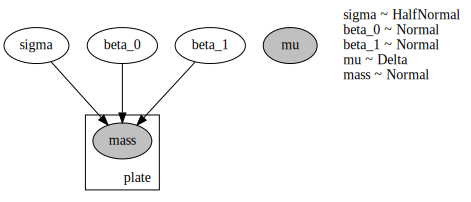

In [6]:
pyro.render_model(
    linear_model, 
    model_args=(adelie_flipper_length, adelie_mass),
    render_distributions=True
    )

In [ ]:
model_321 = AutoLaplaceApproximation(linear_model)
svi = SVI(
    linear_model,
    model_321,
    pyro.optim.Adam({'lr': 0.01}),
    Trace_ELBO(),
    flipper_length=adelie_flipper_length,
    mass=adelie_mass
)

Elbo loss: 1087530651.5757895
Elbo loss: 179395883.982979
Elbo loss: 127925090.11117476
Elbo loss: 84963076.07066269
Elbo loss: 47587655.07687865
Elbo loss: 32240501.48146451
Elbo loss: 21482992.970787298
Elbo loss: 23314826.991697907
Elbo loss: 15787697.856639942
Elbo loss: 16771842.602820786


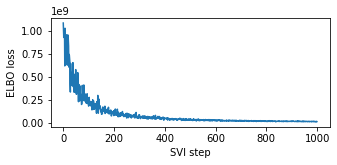

In [30]:
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(linear_model)
adam = pyro.optim.Adam({'lr': 0.01})
elbo = Trace_ELBO()
svi = SVI(linear_model, auto_guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(adelie_flipper_length, adelie_mass)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [31]:
predictive = Predictive(linear_model, guide=auto_guide, num_samples=1000)
svi_samples = predictive(adelie_flipper_length, mass=None)
svi_mass = svi_samples['mass']

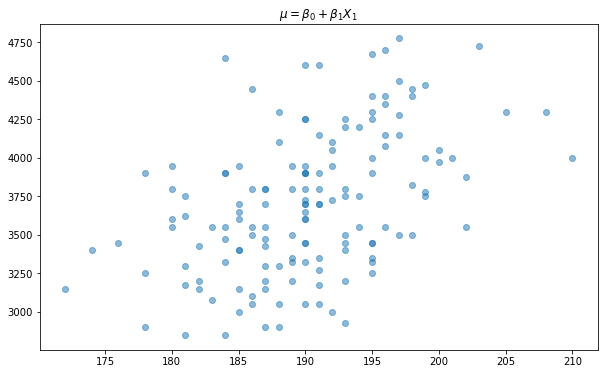

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(adelie_flipper_length.numpy(), adelie_mass.numpy(), alpha=0.5)
#plt.plot(adelie_flipper_length.numpy(), svi_mass.mean(axis=0))
plt.title('$\mu =  \\beta_0 + \\beta_1X_1$')
plt.show()

### Section 3.4.2

In [ ]:
species_filter = penguins['species'].isin(['Adelie', 'Chinstrap'])
penguins = penguins[species_filter]

In [ ]:
penguins['bill_length_mm_centered'] = (penguins['bill_length_mm'] - penguins['bill_length_mm'].mean()) #/ (penguins['bill_length_mm'].std())

In [ ]:
penguins['sex_code'] = pd.Categorical(penguins['sex']).codes
penguins['species_code'] = pd.Categorical(penguins['species']).codes

In [ ]:
penguins['species_code'].value_counts()

In [ ]:
# design matrix
data = torch.tensor(
    penguins['bill_length_mm_centered'].values, dtype=torch.float
    )

outcome = torch.tensor(
    penguins['species_code'].values, dtype=torch.float
    )

In [ ]:
def model(bill_length, outcome=None):
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 10.))

    mu = beta_0 + bill_length * beta_1

    theta = pyro.deterministic('mu', torch.sigmoid(mu))

    with pyro.plate('outcome', bill_length.shape[0]):
        bernoulli_outcome = pyro.sample('bernoulli_outcome', dist.Bernoulli(theta), obs=outcome)
        return bernoulli_outcome

In [ ]:
kernel = NUTS(model)

mcmc = MCMC(
    kernel,
    warmup_steps=500,
    num_samples=1000,
    num_chains=1
)

mcmc.run(data, outcome)

### Posterior

1. sample from posterior

In [ ]:
mcmc.summary()

Using the `Predictive` utility, you can generate samples from the posterior predictive distribution. Here, I generate 1000 samples from the trained model

In [ ]:
samples = mcmc.get_samples(num_samples=1000)

predictive = Predictive(model=model, posterior_samples=samples)
#predictive = Predictive(model=model, num_samples=1000)
mcmc_samples = predictive(bill_length=data, outcome=None)
mcmc_probs = mcmc_samples['mu'].mean(axis=0).numpy()

In [ ]:
predictions = pd.DataFrame(
    {
        'probs': mcmc_probs.flatten(),
        'bill_length': penguins['bill_length_mm'].values,
        'species': penguins['species_code'].values

    }
)

In [ ]:
predictions

In [ ]:
plt.scatter(x=predictions['bill_length'], y=predictions['probs'], c=predictions['species'])

In [ ]:
probs = predictive(bill_length=data)['mu'].numpy()
probs_mean = np.mean(probs, axis=0)

In [ ]:
probs.shape

In [ ]:
probs_ci = np.percentile(probs, q=[1.5, 98.5], axis=0)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x=data + penguins['bill_length_mm'].mean(), y=probs_mean)
#plt.fill_between(probs_mean, probs_ci[0], probs_ci[1])
plt.show()

In [ ]:
az.plot_trace(az.from_pyro(mcmc))
plt.tight_layout()
plt.show()

In [ ]:
coef = mcmc.get_samples(num_samples=5000)

In [ ]:
mu = Predictive(model, posterior_samples=coef)

predictive = Predictive(model=model, num_samples=1000, return_sites=['beta_0', 'beta_1', 'theta', 'probs_species'])

In [ ]:
mu

In [ ]:
predictive(bill_length=10)